In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [2]:
#Read NO-NO2-NOx Series
dataFrame = pd.read_excel("../data/DataAirTrain.xlsx",index_col= 'time', sheet_name="PM1-PM2_5-PM10-TSP")
dataFrame = dataFrame.tail(1000)

In [3]:
dataFrame[['PM-1','PM-2-5','PM-10','TSP']] = dataFrame[['PM-1','PM-2-5','PM-10','TSP']].interpolate(method='linear')

In [4]:
#Fix gap in time index
dataFrame = dataFrame.resample('H').interpolate(method='linear')

<AxesSubplot:xlabel='time'>

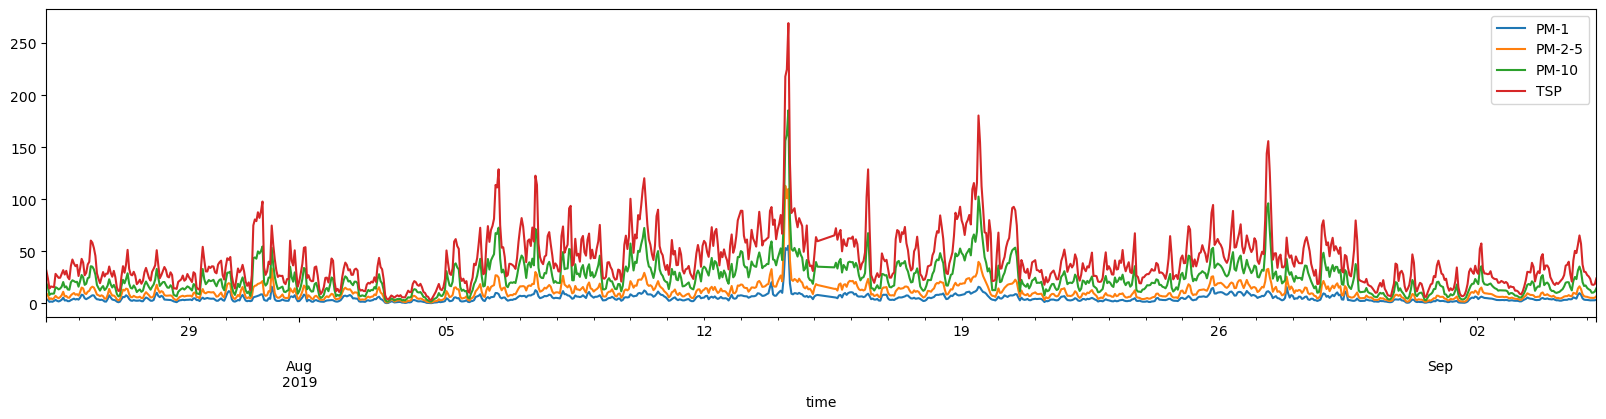

In [5]:
dataFrame.plot(figsize= (20,4))

In [6]:
from statsmodels.tsa.stattools import adfuller
def stationary(var, desc):
    print(
        f"'{desc}' is stationary: "
        f"{adfuller(var)[0] < adfuller(var)[4]['1%']}.")
stationary(dataFrame.iloc[:,0], 'PM1')
stationary(dataFrame.iloc[:,1], 'PM2-5')
stationary(dataFrame.iloc[:,2], 'PM10')
stationary(dataFrame.iloc[:,3], 'TSP')

'PM1' is stationary: True.
'PM2-5' is stationary: True.
'PM10' is stationary: True.
'TSP' is stationary: True.


In [7]:
trainSet = dataFrame[: -48]
testSet = dataFrame[-48: ]
dataFrameCopy = dataFrame
dataFrame = trainSet

In [8]:
def Forecast(ARIMA_model, periods=48):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    # index_of_fc = pd.date_range(dataFrame.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='H')
    index_of_fc = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods = n_periods, freq="H")
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    return [fitted_series, lower_series, upper_series]

In [9]:
def AutoArima(x):
    # return auto_arima(x,d=0)
    return auto_arima(  x, d=None, test = 'adf', D=1, m=24,
                        seasonal = True, error_action = 'ignore')

In [10]:
len = 120
step = 48

In [11]:
resSarima = []
resSarima.append(AutoArima(dataFrame[['PM-1']].tail(len)))
resSarima.append(AutoArima(dataFrame[['PM-2-5']].tail(len)))
resSarima.append(AutoArima(dataFrame[['PM-10']].tail(len)))
resSarima.append(AutoArima(dataFrame[['TSP']].tail(len)))

In [12]:
def Plot(res, test):
    plt.figure(figsize=(15,4))
    plt.plot(res[0], color='darkgreen',label='predict')
    plt.fill_between(res[1].index, 
                    res[1], 
                    res[2], 
                    color='k', alpha=.15)
    plt.title(test.columns.values)
    plt.plot(test,label='test')
    plt.legend()
    plt.show()

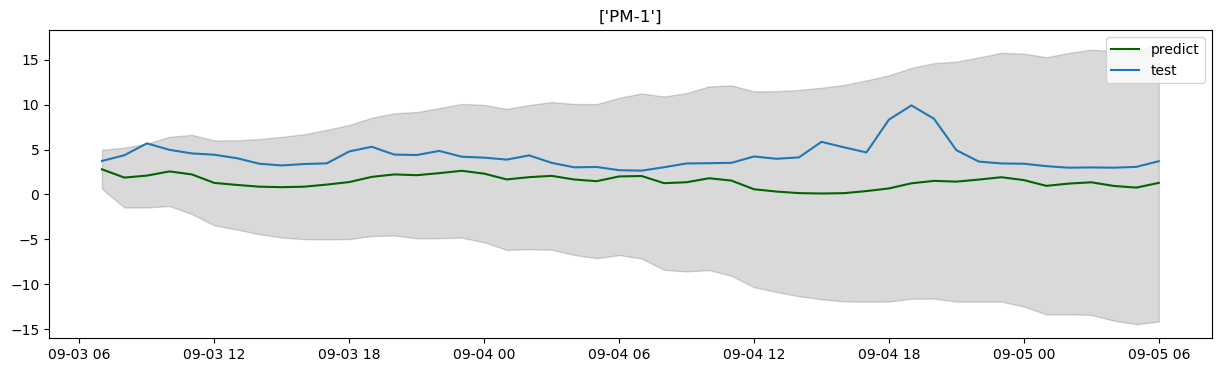

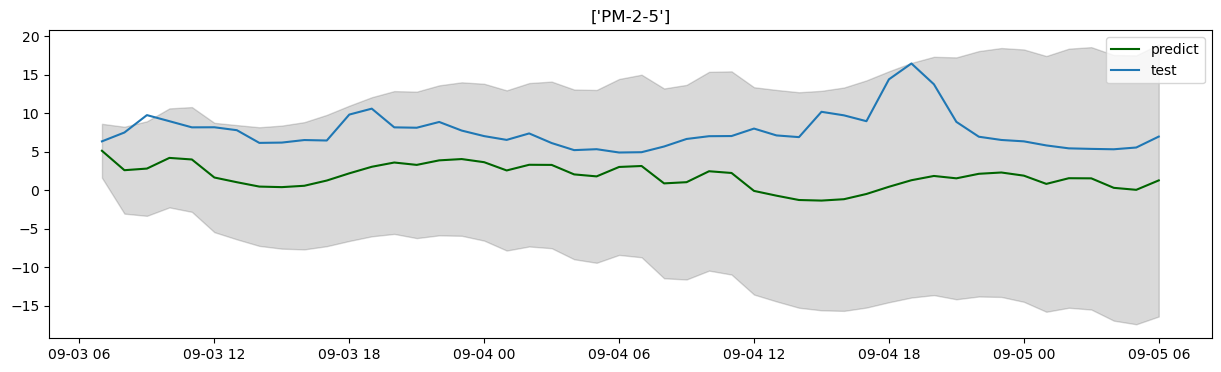

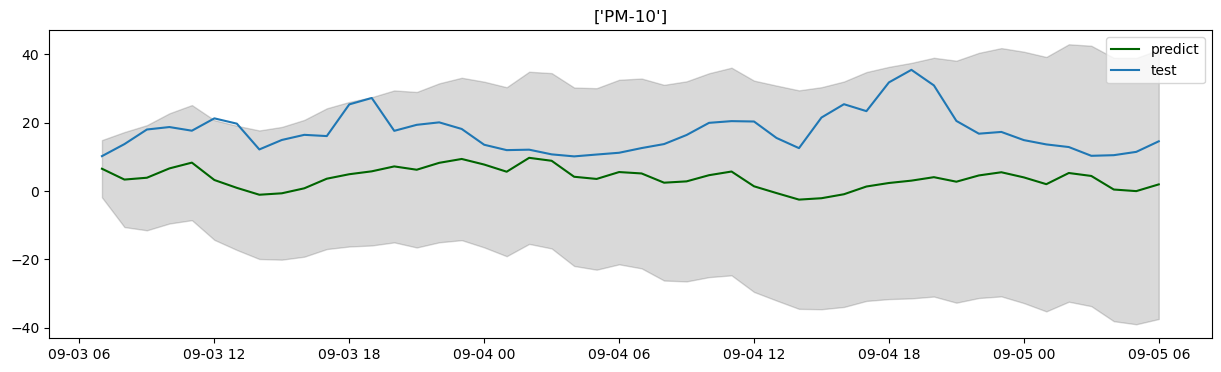

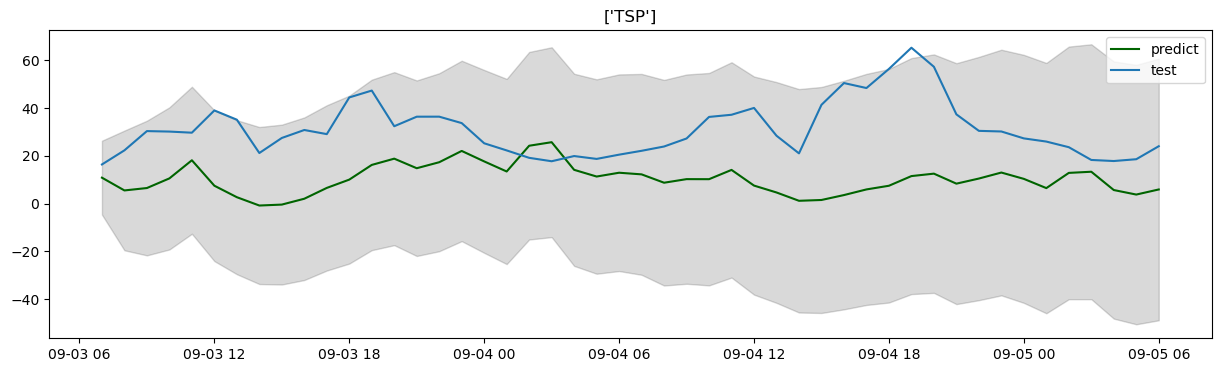

In [13]:
predict = []
res = Forecast(resSarima[0])
Plot(res, testSet[['PM-1']])
predict.append(res[0])

res = Forecast(resSarima[1])
Plot(res, testSet[['PM-2-5']])
predict.append(res[0])

res = Forecast(resSarima[2])
Plot(res, testSet[['PM-10']])
predict.append(res[0])

res = Forecast(resSarima[3])
Plot(res, testSet[['TSP']])
predict.append(res[0])


In [14]:
step = 48
dateTimeIndex = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods=step, freq="H")
idx = pd.Index(dateTimeIndex, name='time')
dataFramePredicted = pd.DataFrame(predict)
dataFramePredicted = dataFramePredicted.transpose()
dataFramePredicted.index = idx
dataFramePredicted.columns = dataFrame.columns.values
# print(dataFramePredicted)


In [15]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
tmp = []
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,0], testSet.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,1], testSet.iloc[:,1]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,2], testSet.iloc[:,2]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,3], testSet.iloc[:,3]))
metric = pd.DataFrame(tmp, index=dataFramePredicted.columns.values)
print(metric)

            mape         me        mae       mpe       rmse      corr  \
PM-1    0.627533  -2.783819   2.783819 -0.627533   3.233160 -0.083546   
PM-2-5  0.748509  -5.884100   5.884100 -0.748509   6.563789 -0.068505   
PM-10   0.756444 -13.530869  13.530869 -0.756444  15.140780 -0.071939   
TSP     0.654579 -20.968666  21.512777 -0.624780  24.808781 -0.075527   

          minmax  
PM-1    0.627533  
PM-2-5  0.748509  
PM-10   0.756444  
TSP     0.650510  


C:\Users\admin\AppData\Local\Temp\ipykernel_5292\1014119381.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_5292\1014119381.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\admin\AppData\Local\Temp\ipykernel_5292\1014119381.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_5292\1014119381.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:,